In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.constants import c
from astropy.time import Time

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.size'] = 14

In [2]:
fs = 1
freq_correction_tx = 13527500/8388593
gnuradio_correction = 1.6
f_sep = 245e3 + gnuradio_correction + freq_correction_tx
freq_correction_rx = 31/2**32 * f_sep
correction_remaining = freq_correction_tx + freq_correction_rx - gnuradio_correction + 20e-6

In [3]:
def open_file(filename, skip=0):
    data = {}
    x = np.fromfile(filename, 'uint8')
    x = x[:x.size//24*24].reshape(-1, 2, 12)
    data['f_offset'] = float(filename[:-len('_unwrap')].split('_')[-1])
    t0 = np.datetime64(filename.split('_')[2])
    data['t'] = t0 + (np.arange(x.shape[0]) / fs * 1e9) * np.timedelta64(1, 'ns')
    data['bpsk_phase'] = (
        x[:, 1, :8].ravel().view('int64').astype('float')
        + x[:, 1, 8:].ravel().view('float32').astype('float') / (2 * np.pi)
    )
    # apply frequency correction to diff_phase
    data['diff_phase'] = (
        x[:, 0, :8].ravel().view('int64').astype('float')
        + x[:, 0, 8:].ravel().view('float32').astype('float') / (2 * np.pi)
        - correction_remaining * np.arange(x.shape[0]) / fs
    )
    data['t'] = data['t'][skip:]
    data['bpsk_phase'] = data['bpsk_phase'][skip:]
    data['diff_phase'] = data['diff_phase'][skip:]
    return data

def range_km(data):
    return -1e-3 * data['diff_phase'][::fs] / f_sep * c

T_range_delta = 100
def range_delta(data, T_range_delta=T_range_delta):
    return np.diff(range_km(data)[::T_range_delta]) * 1e3 / T_range_delta

def remove_average(x):
    return x - np.average(x)

In [4]:
filenames = [
    ('beacons_phases_2022-08-05T20:26:28.994004_tune_-130_unwrap', 100 * fs),
    ('beacons_phases_2022-08-06T08:08:59.380319_tune_-130_unwrap', 100 * fs),
]
data = [open_file(filename, skip) for filename, skip in filenames]

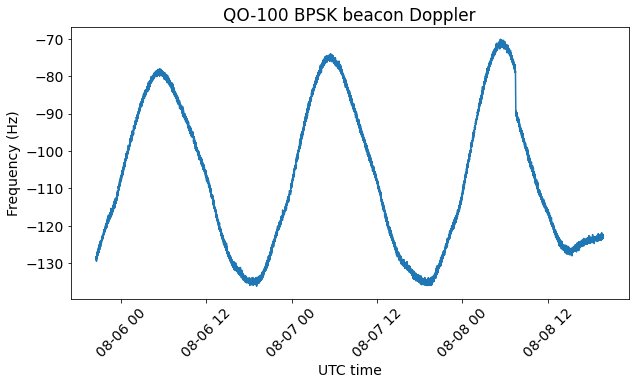

In [5]:
T_freq = 10
for d in data:
    f_doppler = np.diff(d['bpsk_phase'][::T_freq*fs])/T_freq + d['f_offset']
    plt.plot(d['t'][::T_freq*fs][:-1], f_doppler, color='C0')
plt.xticks(rotation=45)
plt.xlabel('UTC time')
plt.ylabel('Frequency (Hz)')
plt.title('QO-100 BPSK beacon Doppler');

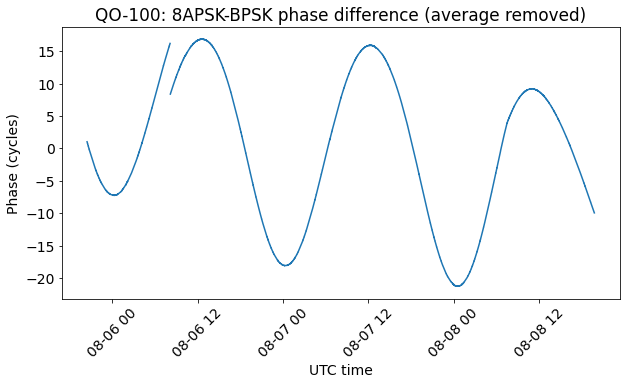

In [6]:
for d in data:
    plt.plot(d['t'][::fs], remove_average(d['diff_phase'][::fs]),
             color='C0')
plt.xticks(rotation=45)
plt.xlabel('UTC time')
plt.ylabel('Phase (cycles)')
plt.title('QO-100: 8APSK-BPSK phase difference (average removed)');

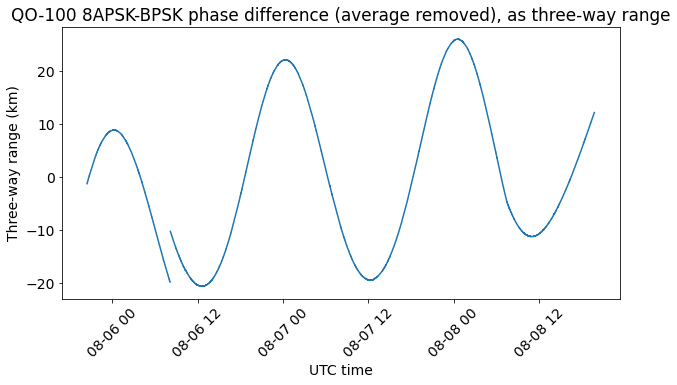

In [7]:
for d in data:
    plt.plot(d['t'][::fs], remove_average(range_km(d)), color='C0')
plt.xticks(rotation=45)
plt.xlabel('UTC time')
plt.ylabel('Three-way range (km)')
plt.title('QO-100 8APSK-BPSK phase difference (average removed), as three-way range');

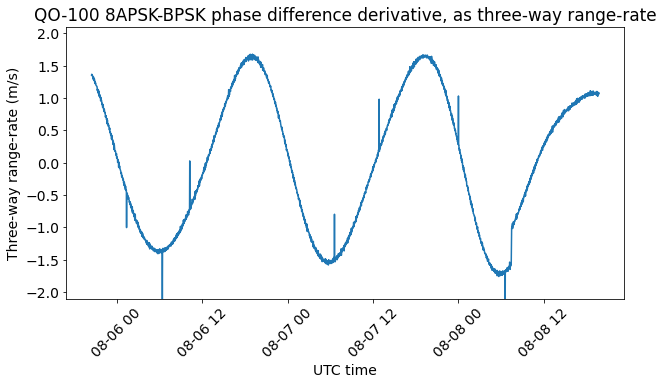

In [8]:
for d in data:
    plt.plot(d['t'][::fs*T_range_delta][:-1], range_delta(d),
             color='C0')
plt.xticks(rotation=45)
plt.xlabel('UTC time')
plt.ylabel('Three-way range-rate (m/s)')
plt.title('QO-100 8APSK-BPSK phase difference derivative, as three-way range-rate')
plt.ylim((-2.1, 2.1));

## Station keeping

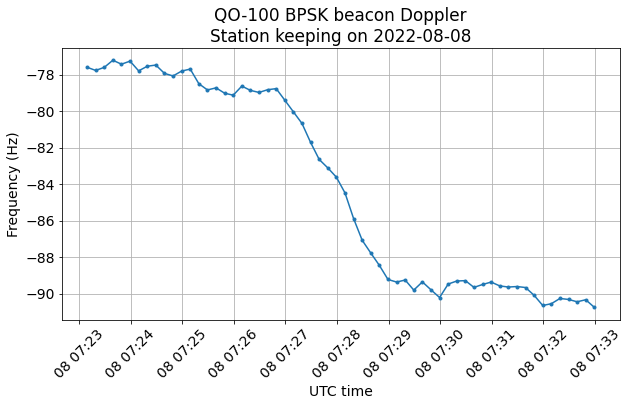

In [9]:
d = data[1]
f_doppler = np.diff(d['bpsk_phase'][::T_freq*fs])/T_freq + d['f_offset']
t_doppler = data[1]['t'][::T_freq*fs][:-1]
tsel = (t_doppler >= np.datetime64('2022-08-08T07:23')) & (t_doppler <= np.datetime64('2022-08-08T07:33'))
plt.plot(t_doppler[tsel], f_doppler[tsel], '.-')
plt.xticks(rotation=45)
plt.xlabel('UTC time')
plt.ylabel('Frequency (Hz)')
plt.title('QO-100 BPSK beacon Doppler\nStation keeping on 2022-08-08')
plt.grid();

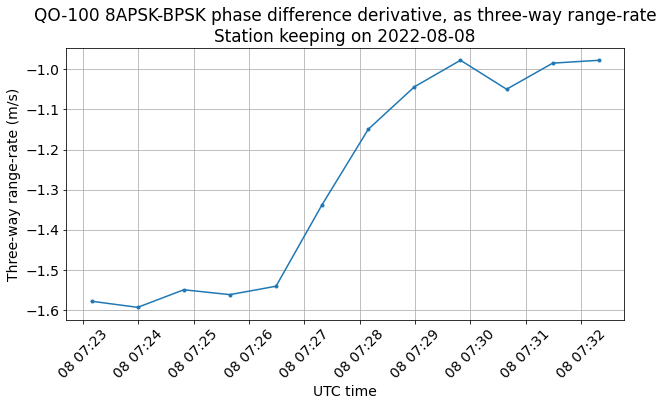

In [10]:
d = data[1]
T_rr = 50
t_rr = d['t'][::fs*T_rr][:-1]
tsel = (t_rr >= np.datetime64('2022-08-08T07:23')) & (t_rr <= np.datetime64('2022-08-08T07:33'))
plt.plot(t_rr[tsel], range_delta(d, T_range_delta=T_rr)[tsel], '.-')
plt.xticks(rotation=45)
plt.xlabel('UTC time')
plt.ylabel('Three-way range-rate (m/s)')
plt.title('QO-100 8APSK-BPSK phase difference derivative, as three-way range-rate\nStation keeping on 2022-08-08')
plt.grid();

## GMAT output

In [11]:
# Write GMD file for GMAT

with open('/tmp/qo100_range.gmd', 'w') as gmd:
    for d in data[1:]:
        for t, r in zip(d['t'][::fs][::100], remove_average(range_km(d))[::100] + 76.984e3):
            tai_mjd = Time(t).tai.jd - 2430000.0
            print(f'{tai_mjd}\tRange\t9015\t{{ 90001 43700 90002 }}\t{r}',
                  file=gmd)
            
with open('/tmp/qo100.gmd', 'w') as gmd:
    for d in data:
        for t, rr in zip(d['t'][::fs*T_range_delta][:-1], range_delta(d)):
            t = t + T_range_delta  # adjust timestamp to end of interval
            rr = rr * 1e-3  # convert from m/s to km/s
            tai_mjd = Time(t).tai.jd - 2430000.0
            print(f'{tai_mjd}\tRangeRate\t9010\t{{ 90001 43700 90002 }}\t1\t{T_range_delta}\t{rr}',
                  file=gmd)

## Phase jumps

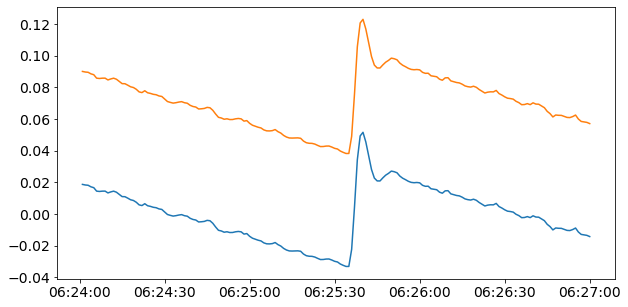

In [12]:
t = data[0]['t']
tsel = (t >= np.datetime64('2022-08-06T06:24')) & (t <= np.datetime64('2022-08-06T06:27'))
plt.plot(t[tsel], scipy.signal.detrend(data[0]['diff_phase'][tsel]))
plt.plot(t[tsel], scipy.signal.detrend(data[0]['diff_phase'][tsel]) + 1/14)

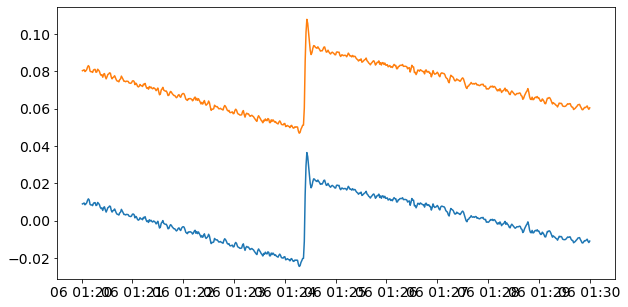

In [13]:
t = data[0]['t']
tsel = (t >= np.datetime64('2022-08-06T01:20')) & (t <= np.datetime64('2022-08-06T01:30'))
plt.plot(t[tsel], scipy.signal.detrend(data[0]['diff_phase'][tsel]))
plt.plot(t[tsel], scipy.signal.detrend(data[0]['diff_phase'][tsel]) + 1/14)

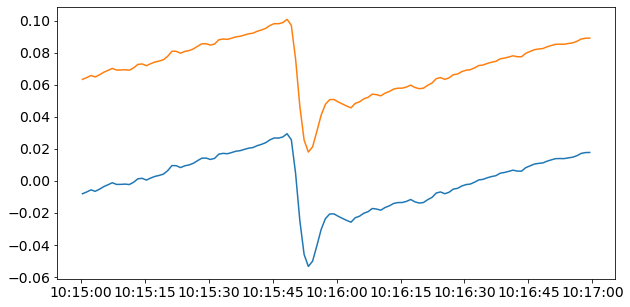

In [14]:
t = data[1]['t']
tsel = (t >= np.datetime64('2022-08-06T10:15')) & (t <= np.datetime64('2022-08-06T10:17'))
plt.plot(t[tsel], scipy.signal.detrend(data[1]['diff_phase'][tsel]))
plt.plot(t[tsel], scipy.signal.detrend(data[1]['diff_phase'][tsel]) + 1/14)

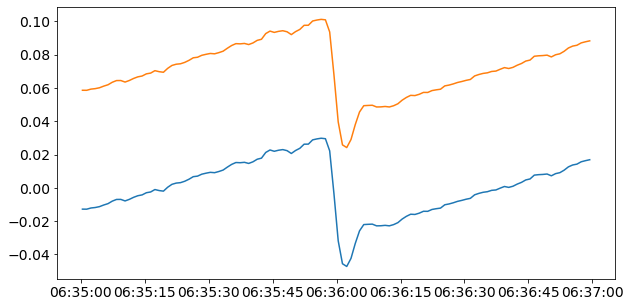

In [15]:
t = data[1]['t']
tsel = (t >= np.datetime64('2022-08-07T06:35')) & (t <= np.datetime64('2022-08-07T06:37'))
plt.plot(t[tsel], scipy.signal.detrend(data[1]['diff_phase'][tsel]))
plt.plot(t[tsel], scipy.signal.detrend(data[1]['diff_phase'][tsel]) + 1/14)

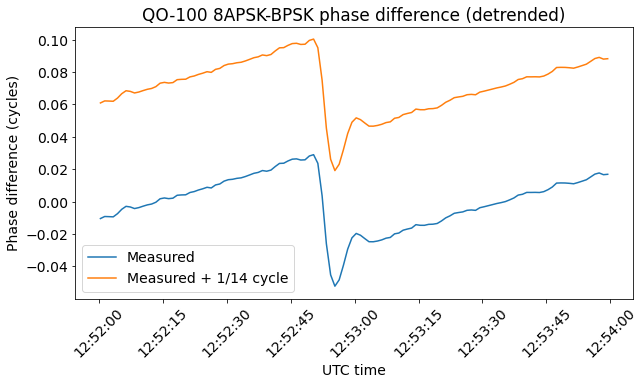

In [16]:
t = data[1]['t']
tsel = (t >= np.datetime64('2022-08-07T12:52')) & (t <= np.datetime64('2022-08-07T12:54'))
plt.plot(t[tsel], scipy.signal.detrend(data[1]['diff_phase'][tsel]), label='Measured')
plt.plot(t[tsel], scipy.signal.detrend(data[1]['diff_phase'][tsel]) + 1/14, label='Measured + 1/14 cycle')
plt.title('QO-100 8APSK-BPSK phase difference (detrended)')
plt.ylabel('Phase difference (cycles)')
plt.xlabel('UTC time')
plt.xticks(rotation=45)
plt.legend();

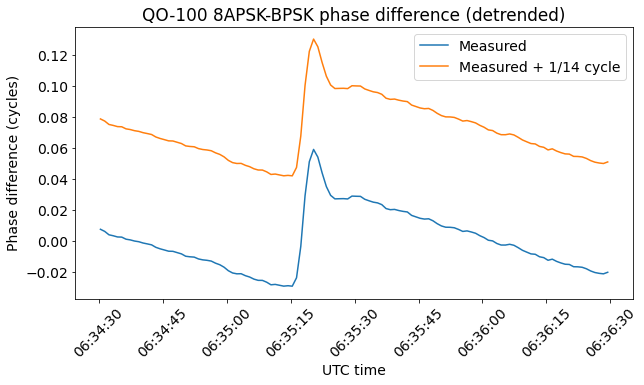

In [17]:
t = data[1]['t']
tsel = (t >= np.datetime64('2022-08-08T06:34:30')) & (t <= np.datetime64('2022-08-08T06:36:30'))
plt.plot(t[tsel], scipy.signal.detrend(data[1]['diff_phase'][tsel]), label='Measured')
plt.plot(t[tsel], scipy.signal.detrend(data[1]['diff_phase'][tsel]) + 1/14, label='Measured + 1/14 cycle')
plt.title('QO-100 8APSK-BPSK phase difference (detrended)')
plt.ylabel('Phase difference (cycles)')
plt.xlabel('UTC time')
plt.xticks(rotation=45)
plt.legend();